# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install --quiet optuna

In [2]:
!pip install -q xgboost

In [3]:
!pip install -q scikit-learn==1.2.2

In [4]:
import sys
!{sys.executable} -m pip install spacy

In [5]:
!{sys.executable} -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 10.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2023-05-03 23:14:16.128216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-05-03 23:14:16.128645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-03 23:14:28.617446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-05-03 23:14:28.617490: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 23:14:28.622186: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ComputerW
2023-05-03 23:14:28.622306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ComputerW


In [6]:
!pip install wordcloud

In [7]:
import pandas as pd
import numpy as np
import re

import time
from time import strftime, localtime

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import notebook

import spacy

import nltk
from nltk.corpus import (
    wordnet,
    stopwords
)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import torch
from transformers import (
    BertTokenizer,
    BertConfig,
    BertModel
)

import optuna

from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.utils import (
    resample,
    shuffle
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from xgboost import XGBRFClassifier

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# uncomment to disable warnings and optuna info logs
# import warnings
# warnings.filterwarnings('ignore')
# optuna.logging.set_verbosity(optuna.logging.WARNING)

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HPbook\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HPbook\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HPbook\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
RANDOM_STATE = 732568

eng_stopwords = stopwords.words('english')

## Подготовка

Тетрадка данного исследования может запускаться по двум сценариям:
 1. сценарий 1: первый запуск тетрадки - при этом:
    - загружается исходный датасет с 159292 комментариями;
    - делается подвыборка объёмом в 15000 комментариев, сбалансированная по классу целевого признака;
    - комментарии в сделанной подвыборке лемматизируются, добавляются в колонку `lemm_text` датасета и сохраняются в отдельный csv файл `datasets/toxic_comments_lemm.csv`
    - далее в исследовании используется подвыборка с лемматизированными комментариями.
 2. сценарий 2: повторный запуск тетрадки - при этом:
    - загружается и используется для исследования датасет `datasets/toxic_comments_lemm.csv`, созданный при запуске первого сценария.
    
Разделение на два сценария запуска сделано в целях экономии времини на лемматизицаии при повторном запуске исследования.

При повторном запуске тетрадки в режиме первого сценария необходимо выставить параметр `run_always_first_scenario` в `True`.

In [9]:
run_always_first_scenario = False

### Загрузка и общая информация

In [10]:
def load_dataset(dataset_name):
    return pd.read_csv('datasets/' + dataset_name,
                       index_col='Unnamed: 0')

In [11]:
try:
    if run_always_first_scenario:
        data = load_dataset('toxic_comments.csv')
    else:
        data = load_dataset('toxic_comments_lemm.csv')
except:
    data = load_dataset('toxic_comments.csv')

In [12]:
is_first_run_scenario = 'lemm_text' not in data.columns
if is_first_run_scenario:
    print('Загружен оригинальный датасет.')
    print('is_first_run_scenario =', is_first_run_scenario)
else:
    print('Загружен обработанный датасет, сокращённого размера и с лемматизированными комментариями.')
    print('is_first_run_scenario =', is_first_run_scenario)

Загружен обработанный датасет, сокращённого размера и с лемматизированными комментариями.
is_first_run_scenario = False


In [13]:
display(data.head())
data.info()

,text,toxic,lemm_text
86291,"""\n\n why you didnt blocked him? \n\nthis user...",0,do not block user http en wikipedia org wiki u...
123822,You are incorrect to assume that Wikipedians s...,0,incorrect assume wikipedians support jewish su...
59275,I'm suprised nobody has told you to read WP:AN...,0,suprise tell read wp anot trophy
13590,"""\n\nTm00627, please stop continuously adding ...",0,tm stop continuously add information article g...
39337,"Im busy right now, but I will have your IP ban...",1,busy right ip ban minute jeez moron


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 86291 to 59079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       15000 non-null  object
 1   toxic      15000 non-null  int64 
 2   lemm_text  14985 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.8+ KB


In [14]:
data.isna().sum()

text          0
toxic         0
lemm_text    15
dtype: int64

In [15]:
data.dropna(inplace=True)

In [16]:
data.toxic.value_counts()

0    13439
1     1546
Name: toxic, dtype: int64

In [17]:
data.toxic.value_counts(1)

0    0.89683
1    0.10317
Name: toxic, dtype: float64

### Создание подвыборки

In [18]:
def get_subsample(df, n):
    return df.sample(n)

In [19]:
if is_first_run_scenario:
    data = get_subsample(data, 15000)

In [20]:
data.shape

(14985, 3)

In [21]:
data.toxic.value_counts()

0    13439
1     1546
Name: toxic, dtype: int64

In [22]:
data.toxic.value_counts(1)

0    0.89683
1    0.10317
Name: toxic, dtype: float64

### Лемматизация

In [23]:
POS_TAGS = {
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'J': wordnet.ADJ,
    'R': wordnet.ADV
}

class TextLemmatizer(object):
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(eng_stopwords)
        
    def get_wordnet_pos(self, word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        return POS_TAGS.get(tag, wordnet.NOUN)

    def lemmatize(self, text):
        word_tokens = word_tokenize(re.sub('[^a-zA-Z]', ' ', text))
        filtered_word_tokens = [word.lower() for word in word_tokens\
                                if not word.lower() in self.stop_words]
        lemmas = [self.lemmatizer.lemmatize(word, self.get_wordnet_pos(word))\
                  for word in filtered_word_tokens]
        return ' '.join(lemmas)

In [24]:
def lemmatize_and_save_to_csv(df):
    lemmatizer = TextLemmatizer()
    batch_size = 1000
    lemm_text = pd.Series(dtype='object')
    for i in notebook.tqdm(range((df.shape[0] // batch_size) + 1)):
        batch = df[batch_size*i:batch_size*(i+1)]
        df_lemmatized = batch.text.apply(lambda text: lemmatizer.lemmatize(text))
        lemm_text = pd.concat([lemm_text, df_lemmatized], axis=0)

    df['lemm_text'] = lemm_text
    df.dropna(inplace=True)
    df.to_csv('datasets/toxic_comments_lemm.csv')
    return df

In [25]:
class SpacyEnTextLemmatizer(object):
    
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.stop_words = nlp.Defaults.stop_words
    
    def lemmatize(self, text):
        cleaned_text = re.sub('[^a-zA-Z]', ' ', text)
        cleaned_text = ' '.join(
            [word for word in cleaned_text.split()
             if word.lower() not in self.stop_words]
        )
        tokens_doc = self.nlp(cleaned_text)
        lemmatized_tokens = [token.lemma_.lower() \
                             for token in tokens_doc if len(token) > 1]
        return ' '.join(lemmatized_tokens)

In [26]:
def lemmatize_with_spacy_and_save_to_csv(df):
    lemmatizer = SpacyEnTextLemmatizer()
    batch_size = 1000
    lemm_text = pd.Series(dtype='object')
    for i in notebook.tqdm(range((df.shape[0] // batch_size) + 1)):
        batch = df[batch_size*i:batch_size*(i+1)]
        df_lemmatized = batch.text.apply(lambda text: lemmatizer.lemmatize(text))
        lemm_text = pd.concat([lemm_text, df_lemmatized], axis=0)
    df['lemm_text'] = lemm_text
    df.dropna(inplace=True)
    df.to_csv('datasets/toxic_comments_lemm.csv')
    return df

In [27]:
if is_first_run_scenario:
#     data = lemmatize_and_save_to_csv(data)
    data = lemmatize_with_spacy_and_save_to_csv(data)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14985 entries, 86291 to 59079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       14985 non-null  object
 1   toxic      14985 non-null  int64 
 2   lemm_text  14985 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.3+ KB


In [29]:
data.head()

,text,toxic,lemm_text
86291,"""\n\n why you didnt blocked him? \n\nthis user...",0,do not block user http en wikipedia org wiki u...
123822,You are incorrect to assume that Wikipedians s...,0,incorrect assume wikipedians support jewish su...
59275,I'm suprised nobody has told you to read WP:AN...,0,suprise tell read wp anot trophy
13590,"""\n\nTm00627, please stop continuously adding ...",0,tm stop continuously add information article g...
39337,"Im busy right now, but I will have your IP ban...",1,busy right ip ban minute jeez moron


### Графики количества слова в классах

In [30]:
def plot_words_counts(count_vect, texts, label):
    bow = count_vect.fit_transform(texts)
    all_words = count_vect.get_feature_names_out()
    all_counts = bow.sum(axis=0).tolist()[0]
    all_words, all_counts = zip(*[(w, c) for c, w in sorted(zip(all_counts, all_words), reverse=True)])
    df_to_plot = pd.DataFrame({'words': all_words, 'counts': all_counts})
    df_to_plot.iloc[:50].plot.bar(x='words', y='counts', rot=90, figsize=(15, 5), label=label);

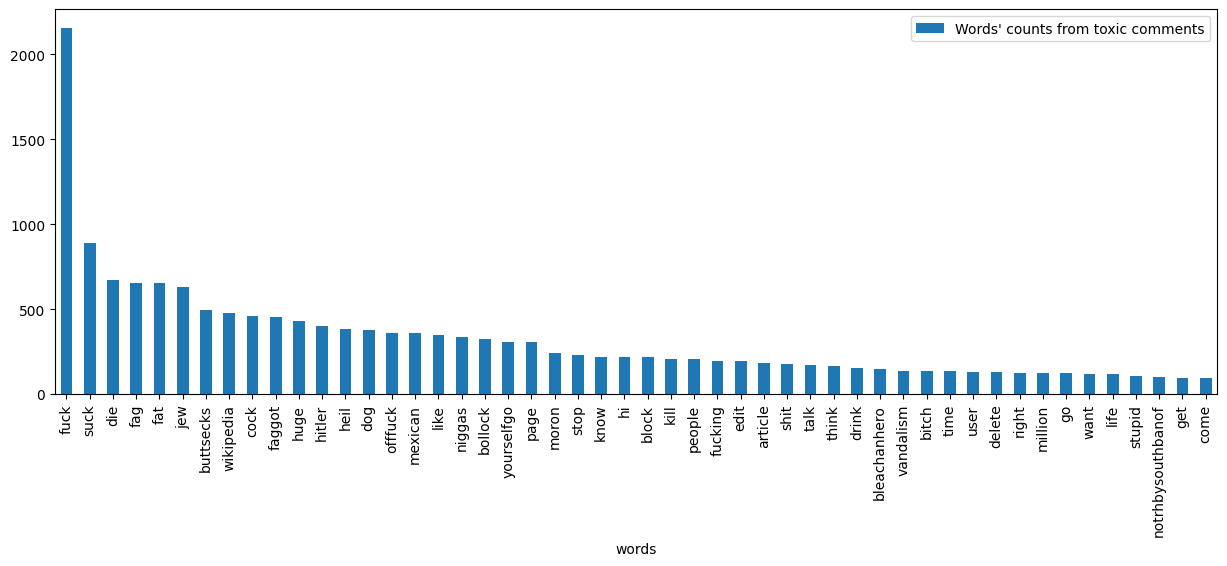

In [31]:
plot_words_counts(CountVectorizer(stop_words=eng_stopwords),
                  data.loc[data.toxic == 1].lemm_text,
                  'Words\' counts from toxic comments')

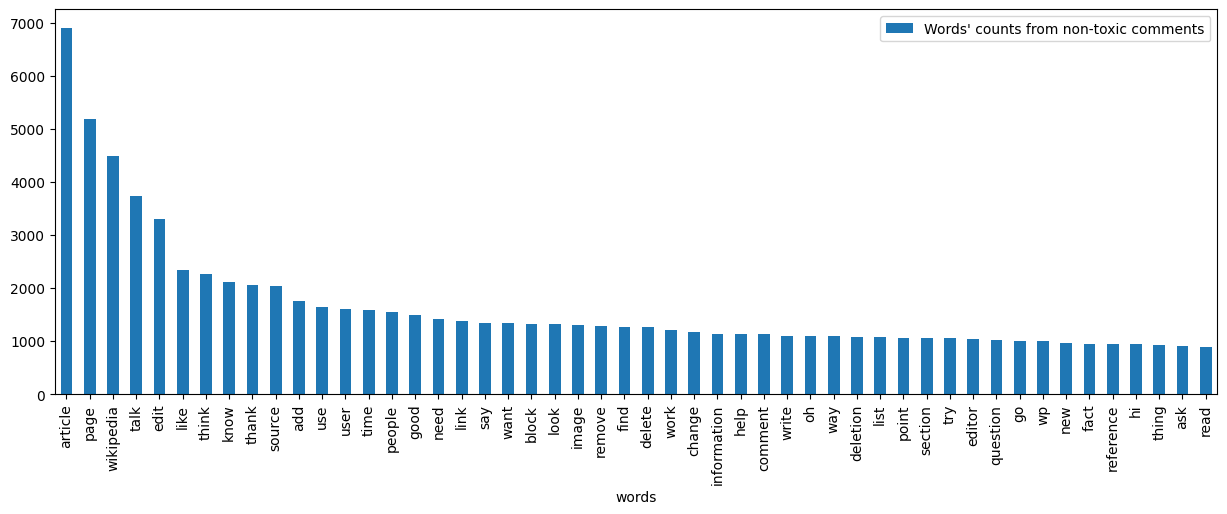

In [32]:
plot_words_counts(CountVectorizer(stop_words=eng_stopwords), 
                 data.loc[data.toxic == 0].lemm_text,
                 'Words\' counts from non-toxic comments')

Из графиков видно, что наборы слов в комментариях разных классов различаются.

In [33]:
def plot_wordcloud(count_vect, texts, title):
    bow = count_vect.fit_transform(texts)
    all_words = count_vect.get_feature_names_out()
    all_counts = bow.sum(axis=0).tolist()[0]
    all_words, all_counts = zip(*[(w, c) for c, w in sorted(zip(all_counts, all_words), reverse=True)])
    df_word_counts = pd.DataFrame({'words': all_words, 'counts': all_counts})
    
    word_counts = {word_count[0]: word_count[1] \
                   for word_count in df_word_counts.values[:100]}
    
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(frequencies=word_counts)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

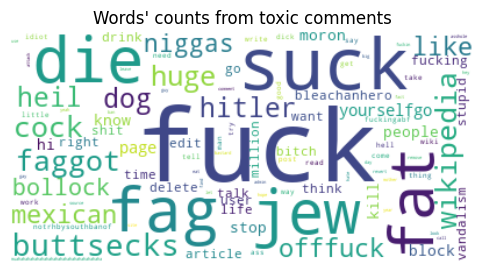

In [34]:
plot_wordcloud(CountVectorizer(stop_words=eng_stopwords),
                  data.loc[data.toxic == 1].lemm_text,
                  'Words\' counts from toxic comments')

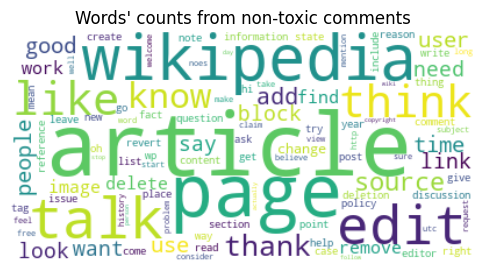

In [35]:
plot_wordcloud(CountVectorizer(stop_words=eng_stopwords), 
                 data.loc[data.toxic == 0].lemm_text,
                 'Words\' counts from non-toxic comments')

### Подготовка embeddings

#### TF-IDF

In [36]:
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

In [37]:
train.shape, test.shape

((11238, 3), (3747, 3))

In [38]:
train.toxic.value_counts(1)

0    0.896334
1    0.103666
Name: toxic, dtype: float64

In [39]:
test.toxic.value_counts(1)

0    0.898319
1    0.101681
Name: toxic, dtype: float64

In [40]:
corpus_train = train['lemm_text'].values
corpus_test = test['lemm_text'].values

In [41]:
count_tf_idf = TfidfVectorizer(stop_words=eng_stopwords)
count_tf_idf.fit(corpus_train)

features_train_tfidf = count_tf_idf.transform(corpus_train)
features_test_tfidf = count_tf_idf.transform(corpus_test)

In [42]:
features_train = train[['lemm_text']]
features_test = test[['lemm_text']]

In [43]:
target_train = train.toxic
target_test = test.toxic

In [44]:
features_train.shape, features_test.shape

((11238, 1), (3747, 1))

In [45]:
target_train.shape, target_test.shape

((11238,), (3747,))

#### BERT

Часть исследования по подготовке BERT embeddings также запускается по двум сценариями:
 1. сценарий 1: первый запуск тетрадки - при этом, запускается создание эмбеддингов, и сохранение их в файл 'datasets/bert_embeddings.csv';
 2. сценарий 2: повторный запуск тетрадки - при этом, созданные при первом запуске эмбеддинги загружаются из файла 'datasets/bert_embeddings.csv';
 
NB! Для корректной работы кода создания эмбеддингов в первом сценарии необходимо убедиться, что в корненой папке (в папке, в которой лежит тетрадка исследования) находятся следующие файлы, необходимые для BERT модели:
 - 'datasets/bert/cased_L-12_H-768_A-12/vocab.txt`;
 - 'datasets/bert/cased_L-12_H-768_A-12/bert_config.json`;

При необходимости их можно загрузить для модели `BERT-base, English, cased, 12-layer, 768-hidden, 12-heads, 110M parameters` по ссылке [deeppavlov](http://files.deeppavlov.ai/deeppavlov_data/bert/cased_L-12_H-768_A-12.zip|)

При повторном запуске тетрадки в режиме первого сценария необходимо выставить параметр `run_always_bert_embeddings_creation` в `True`.

In [46]:
run_always_bert_embeddings_creation = False

In [47]:
try:
    if run_always_bert_embeddings_creation:
        raise Exception()
    bert_embeddings = pd.read_csv(
        'datasets/bert_embeddings.csv', index_col='Unnamed: 0')
    is_bert_embeddings_prepared = True
    print('BERT embeddings загружены из файла \'datasets/bert_embeddings.csv\'')
    print('is_bert_embeddings_prepared =', is_bert_embeddings_prepared)
except:
    is_bert_embeddings_prepared = False
    print('Файл с BERT embeddings не найден')
    print('is_bert_embeddings_prepared =', is_bert_embeddings_prepared)

BERT embeddings загружены из файла 'datasets/bert_embeddings.csv'
is_bert_embeddings_prepared = True


In [48]:
def time_str(timestamp):
    return strftime('%Y-%m-%d %H:%M:%S', localtime(timestamp))

In [49]:
def tokenize_with_bert(data):
    print(time_str(time.time()),
          '[INFO] Загрузка словаря для BertTokenizer из файла '
          + '\'datasets/bert/unitary_toxic-bert/vocab.txt\' ...')
    
    tokenizer = BertTokenizer(
        vocab_file='datasets/bert/unitary_toxic-bert/vocab.txt')
    print(time_str(time.time()), '[INFO] Словарь загружен.')
    
    
    print(time_str(time.time()), '[INFO] Старт токенизации текста ...')
    
    tokenized = data.text.apply(
        lambda text: tokenizer.encode(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=512
        )
    )
    print(time_str(time.time()), '[INFO] Токенизации текста завершена.')
    
    return tokenized

In [50]:
def creat_embeddings(model, padded, attention_mask):
    batch_size = 100
    embeddings = []
    
    print(time_str(time.time()), '[INFO] Старт создания embeddings ...')
    
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
        del batch
        del attention_mask_batch
        del batch_embeddings
        
    print(time_str(time.time()), '[INFO] Создания embeddings завершено.')
    
    return np.concatenate(embeddings)

In [51]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [52]:
def prepare_bert_embeddings(data):
    
    print(time_str(time.time()), '[INFO] Старт создания BERT embeddings ...')
    
    tokenized = tokenize_with_bert(data)
    
    max_length = max(map(len, tokenized.to_list()))
    padded = np.array([i + [0]*(max_length - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    
    print(time_str(time.time()),
          '[INFO] Загрузка конфига для BertModel из файла '
          + '\'datasets/bert/unitary_toxic-bert/config.json\' ...')
    config = BertConfig.from_json_file(
        'datasets/bert/unitary_toxic-bert/config.json')
    
    print(time_str(time.time()),
          '[INFO] Загрузка модели BertModel \'unitary/toxic-bert\' ...')
    model = BertModel.from_pretrained('unitary/toxic-bert', config=config)
    
    embeddings = creat_embeddings(model, padded, attention_mask)
    
    bert_embeddings = pd.DataFrame(embeddings, index=data.index)
    bert_embeddings['toxic'] = data.toxic
    bert_embeddings.to_csv('datasets/bert_embeddings.csv')
    
    print(time_str(time.time()),
          '[INFO] BERT embeddings сохранены в файл datasets/bert_embeddings.csv')
    
    print(time_str(time.time()), '[INFO] BERT embeddings созданы.')
    
    return bert_embeddings

In [53]:
if not is_bert_embeddings_prepared:
    bert_embeddings = prepare_bert_embeddings(data.sample(n=1000))
else:
    print('BERT embeddings уже загружены из файла')

BERT embeddings уже загружены из файла


In [54]:
bert_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 19692 to 4379
Columns: 769 entries, 0 to toxic
dtypes: float64(768), int64(1)
memory usage: 5.9 MB


In [55]:
bert_embeddings.head(3).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,toxic
19692,-0.61,-0.93,0.68,-0.48,1.20,0.49,0.41,-0.09,-0.59,-0.76,0.22,-0.54,-0.08,-0.92,-0.62,0.48,-0.36,-0.99,-0.36,-1.04,0.43,-0.99,-0.13,0.14,-0.73,-0.34,-0.47,-1.07,-0.41,0.85,-0.95,1.05,0.53,0.54,0.68,1.19,0.72,0.20,0.73,0.96,-0.01,-0.56,1.01,-0.64,0.18,0.53,-0.26,-0.87,-1.18,-0.99,-0.07,0.87,0.77,0.83,-0.77,0.52,-0.14,-0.12,-0.55,-0.97,-1.15,-0.64,0.70,0.70,-0.69,0.35,-0.72,0.56,-0.37,-0.05,0.13,0.47,-0.32,0.48,0.22,0.91,-0.64,-0.91,1.12,0.82,-0.71,0.20,0.64,-0.53,0.97,-0.54,-0.56,-0.13,-0.11,1.07,0.76,-0.81,-0.70,0.53,-0.48,-1.09,-0.01,0.64,0.38,1.10,-0.25,0.14,-0.11,-0.14,-0.83,-0.85,-0.79,-0.86,0.43,0.24,0.25,-0.48,0.64,-0.81,-0.84,0.17,0.21,0.09,0.36,0.00,-0.70,0.92,0.69,0.40,0.43,0.16,0.22,-0.84,0.89,0.43,0.49,0.36,0.52,-0.48,0.11,0.00,-0.54,-0.54,0.51,-0.60,0.23,1.02,0.25,0.56,0.37,0.72,-0.32,-0.27,0.70,1.19,1.10,0.56,-0.69,-0.81,-0.45,0.13,-0.44,0.99,-0.66,-0.05,0.43,1.12,-0.96,-0.37,-0.63,-0.31,0.04,-0.35,-0.17,-0.49,-0.42,-0.74,0.74,0.71,-0.69,-0.29,0.11,-0.04,0.80,-0.27,-0.14,0.48,0.37,-1.08,0.70,-0.44,

In [56]:
bert_embeddings.toxic.value_counts(1)

0    0.888
1    0.112
Name: toxic, dtype: float64

In [57]:
features_bert = bert_embeddings.drop(columns='toxic').values
target_bert = bert_embeddings.toxic

In [58]:
features_train_bert, features_test_bert, target_train_bert, target_test_bert = \
    train_test_split(features_bert, target_bert, test_size=0.5, random_state=RANDOM_STATE)

In [59]:
features_train_bert.shape, target_train_bert.shape

((500, 768), (500,))

In [60]:
features_test_bert.shape, target_test_bert.shape

((500, 768), (500,))

## Обучение

In [61]:
ON_TRAIN = 'on train'
ON_TEST = 'on test'
TF_IDF_EMBEDDINGS = 'TF-IDF embeddings'
BERT_EMBEDDINGS = 'BERT embeddings'
F1_SCORE = 'f1 score'

report_columns = [
    (TF_IDF_EMBEDDINGS, ON_TRAIN, F1_SCORE),
    (TF_IDF_EMBEDDINGS, ON_TEST, F1_SCORE),
    (BERT_EMBEDDINGS, ON_TRAIN, F1_SCORE),
    (BERT_EMBEDDINGS, ON_TEST, F1_SCORE)
]
report_columns = pd.MultiIndex.from_tuples(report_columns)

report = pd.DataFrame(columns=report_columns)
report['model'] = []
report.set_index('model', inplace=True)
report

Empty DataFrame
Columns: [(TF-IDF embeddings, on train, f1 score), (TF-IDF embeddings, on test, f1 score), (BERT embeddings, on train, f1 score), (BERT embeddings, on test, f1 score)]
Index: []

In [62]:
def update_report(model_name, embeddings_type, f1_score_train, f1_score_test):
    
    report.loc[model_name, (embeddings_type, ON_TRAIN, F1_SCORE)] = \
        np.float64(f1_score_train).round(3)
    
    report.loc[model_name, (embeddings_type, ON_TEST, F1_SCORE)] = \
        np.float64(f1_score_test).round(3)
    
    print('Результаты обучения модели', model_name)
    display(report.loc[model_name][[(embeddings_type)]])

In [63]:
def update_report_tfidf(model_name, f1_score_train, f1_score_test):
    update_report(model_name, TF_IDF_EMBEDDINGS, f1_score_train, f1_score_test)

In [64]:
def update_report_bert(model_name, f1_score_train, f1_score_test):
    update_report(model_name, BERT_EMBEDDINGS, f1_score_train, f1_score_test)

### TF-IDF признаки

In [65]:
def tune(objective, n_trials=10):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    best_score = study.best_value
    best_params = study.best_params
    print('Best score:', best_score)
    print('Best parameters:', best_params)
    print()
    return best_score, best_params

In [66]:
class TextColumnSelector():
    
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return X[self.columns]

In [67]:
def create_tfidf_pipeline(model):
    return Pipeline([
        ('text_selector', TextColumnSelector('lemm_text')),
        ('tfidf', TfidfVectorizer(stop_words=eng_stopwords)),
        ('model', model)
    ])

#### Модель `LogisticRegression`

In [68]:
def log_reg_tfidf_objective(trial):
    params = {}
    params['C'] = trial.suggest_float('C', 0.0001, 10)
    params['random_state'] = RANDOM_STATE

    model = LogisticRegression(**params)

    return cross_val_score(
        create_tfidf_pipeline(model),
        features_train,
        target_train,
        scoring='f1',
        n_jobs=-1
    ).mean()

In [69]:
# %%time
# log_reg_score, log_reg_params = tune(log_reg_tfidf_objective, n_trials=10)
# uncomment for tuning

In [70]:
# comment this cell when tuning
log_reg_score = 0.6748201656403406
log_reg_params = {'C': 9.588926131542193}
# the parameter values were obtained during the tuning

In [71]:
log_reg_model = LogisticRegression(**log_reg_params, random_state=RANDOM_STATE)
log_reg_model.fit(features_train_tfidf, target_train)

D:\Programs\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=9.588926131542193, random_state=732568)

In [72]:
update_report_tfidf(
    type(log_reg_model).__name__,
    log_reg_score,
    f1_score(target_test, log_reg_model.predict(features_test_tfidf))
)

Результаты обучения модели LogisticRegression


TF-IDF embeddings  on train  f1 score    0.675
                   on test   f1 score    0.648
Name: LogisticRegression, dtype: object

#### Модель `RandomForestClassifier`

In [73]:
def random_forest_tfidf_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 5, 300)
    params['max_depth'] = trial.suggest_int('max_depth', 7, 35)
    
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    params['class_weight']='balanced'

    model = RandomForestClassifier(**params)

    return cross_val_score(
        create_tfidf_pipeline(model),
        features_train,
        target_train,
        cv=3,
        scoring='f1'
    ).mean()

In [74]:
# %%time
# random_forest_score, random_forest_params = tune(random_forest_tfidf_objective, n_trials=10)
# uncomment for tuning

In [75]:
# comment this cell when tuning
random_forest_score = 0.5014335787371529
random_forest_params = {'n_estimators': 244, 'max_depth': 32}
# the parameter values were obtained during the tuning

In [76]:
random_forest_model = RandomForestClassifier(
    **random_forest_params,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
random_forest_model.fit(features_train_tfidf, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=32, n_estimators=244,
                       n_jobs=-1, random_state=732568)

In [77]:
update_report_tfidf(
    type(random_forest_model).__name__,
    random_forest_score,
    f1_score(target_test, random_forest_model.predict(features_test_tfidf))
)

Результаты обучения модели RandomForestClassifier


TF-IDF embeddings  on train  f1 score    0.501
                   on test   f1 score    0.469
Name: RandomForestClassifier, dtype: object

#### Модель `CatBoostClassifier`

In [78]:
EARLY_STOPPING_ROUNDS = 50

In [79]:
def catboost_clf_objective(trial, features, train):
    params = {}
    params['iterations'] = trial.suggest_int('iterations', 10, 300)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 1)
    params['depth'] = trial.suggest_int('depth', 1, 10)
    
    params['eval_metric'] = 'F1'
    params['random_state'] = RANDOM_STATE
    params['logging_level'] = 'Silent'
    params['text_features']=['lemm_text']
    
    model = CatBoostClassifier(**params)
    
    return cross_val_score(
        model,
        features,
        train,
        cv=3,
        scoring='f1'
    ).mean()

In [80]:
catboost_clf_tfidf_objective = \
    lambda trial: catboost_clf_objective(trial, features_train, target_train)

In [81]:
# %%time
# catboost_study = optuna.create_study(direction='maximize')
# catboost_study.optimize(catboost_clf_tfidf_objective, n_trials=8, n_jobs=-1)
# uncomment for tuning

In [82]:
# uncomment for tuning
# catboost_clf_score = catboost_study.best_value
# catboost_clf_params = catboost_study.best_params
# print('Best score:', catboost_clf_score)
# print('Best parameters:', catboost_clf_params)

In [83]:
# comment this cell when tuning
catboost_clf_score = 0.6942997067485047
catboost_clf_params = {'iterations': 177, 'learning_rate': 0.9408051172890137, 'depth': 5}
# the parameter values were obtained during the tuning

In [84]:
catboost_clf = CatBoostClassifier(
    **catboost_clf_params,
    eval_metric='F1',
    random_state=RANDOM_STATE,
    logging_level='Silent',
    text_features=['lemm_text']
)

In [85]:
%%time
catboost_clf.fit(features_train, target_train)

CPU times: total: 48.8 s
Wall time: 10.6 s


In [86]:
update_report_tfidf(
    type(catboost_clf).__name__,
    catboost_clf_score,
    f1_score(target_test, catboost_clf.predict(features_test))
)

Результаты обучения модели CatBoostClassifier


TF-IDF embeddings  on train  f1 score    0.694
                   on test   f1 score    0.661
Name: CatBoostClassifier, dtype: object

#### Модель `XGBRFClassifier`

In [87]:
def xgb_clf_tfidf_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int("n_estimators", 100, 700)
    params['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 1)
    params['max_depth'] = trial.suggest_int("max_depth", 5, 15)
    
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    
    model = XGBRFClassifier(**params)  
    
    return cross_val_score(
        create_tfidf_pipeline(model),
        features_train,
        target_train,
        cv=3,
        scoring='f1'
    ).mean()

In [88]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_clf_tfidf_objective, n_trials=5, n_jobs=-1)
# uncomment for tuning

In [89]:
# uncomment for tuning
# xgb_clf_score = study.best_value
# xgb_clf_params = study.best_params
# print('Best score:', xgb_clf_score)
# print('Best parameters:', xgb_clf_params)

In [90]:
# comment this cell when tuning
xgb_clf_score = 0.6397607754950502
xgb_clf_params = {'n_estimators': 687, 'learning_rate': 0.8148094976938288, 'max_depth': 15}
# the parameter values were obtained during the tuning

In [91]:
xgb_model = XGBRFClassifier(
    **xgb_clf_params,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

In [92]:
%%time
xgb_model.fit(
    features_train_tfidf,
    target_train,
    verbose=False
)

CPU times: total: 10min 22s
Wall time: 1min 27s


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.8148094976938288,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=15, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=687, n_jobs=-1, num_parallel_tree=None,
                objective='binary:logistic', predictor=None,
                random_state=732568, ...)

In [93]:
update_report_tfidf(
    type(xgb_model).__name__,
    xgb_clf_score,
    f1_score(target_test, xgb_model.predict(features_test_tfidf))
)

Результаты обучения модели XGBRFClassifier


TF-IDF embeddings  on train  f1 score     0.64
                   on test   f1 score    0.615
Name: XGBRFClassifier, dtype: object

### BERT embeddings

#### Модель `LogisticRegression`

In [94]:
def log_reg_bert_objective(trial):
    params = {}
    params['C'] = trial.suggest_float('C', 0.0001, 5)
    params['random_state'] = RANDOM_STATE

    model = LogisticRegression(**params)

    return cross_val_score(
        model,
        features_train_bert,
        target_train_bert,
        scoring='f1',
        n_jobs=-1
    ).mean()

In [95]:
# %%time
# log_reg_bert_score, log_reg_bert_params = tune(log_reg_bert_objective, n_trials=10)
# uncomment for tuning

In [96]:
# comment this cell when tuning
log_reg_bert_score = 0.9513043478260869
log_reg_bert_params = {'C': 1.1360625747888504}
# the parameter values were obtained during the tuning

In [97]:
log_reg_bert_model = LogisticRegression(**log_reg_bert_params, random_state=RANDOM_STATE)
log_reg_bert_model.fit(features_train_bert, target_train_bert)

LogisticRegression(C=1.1360625747888504, random_state=732568)

In [98]:
update_report_bert(
    type(log_reg_bert_model).__name__,
    log_reg_bert_score,
    f1_score(target_test_bert, log_reg_bert_model.predict(features_test_bert))
)

Результаты обучения модели LogisticRegression


BERT embeddings  on train  f1 score    0.951
                 on test   f1 score    0.941
Name: LogisticRegression, dtype: object

#### Модель `RandomForestClassifier`

In [99]:
def random_forest_bert_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 5, 200)
    params['max_depth'] = trial.suggest_int('max_depth', 7, 25)

    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    params['class_weight']='balanced'

    model = RandomForestClassifier(**params)

    return cross_val_score(
        model,
        features_train_bert,
        target_train_bert,
        cv=3,
        scoring='f1'
    ).mean()

In [100]:
# %%time
# random_forest_bert_score, random_forest_bert_params = \
#     tune(random_forest_bert_objective, n_trials=30)
# uncomment for tuning

In [101]:
# comment this cell when tuning
random_forest_bert_score = 0.9523809523809524
random_forest_bert_params = {'n_estimators': 98, 'max_depth': 15}
# the parameter values were obtained during the tuning

In [102]:
random_forest_bert_model = RandomForestClassifier(
    **random_forest_bert_params,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_forest_bert_model.fit(features_train_bert, target_train_bert)

RandomForestClassifier(max_depth=15, n_estimators=98, n_jobs=-1,
                       random_state=732568)

In [103]:
update_report_bert(
    type(random_forest_bert_model).__name__,
    random_forest_bert_score,
    f1_score(target_test_bert, random_forest_bert_model.predict(features_test_bert))
)

Результаты обучения модели RandomForestClassifier


BERT embeddings  on train  f1 score    0.952
                 on test   f1 score    0.958
Name: RandomForestClassifier, dtype: object

#### Модель `CatBoostClassifier`

In [104]:
def catboost_clf_bert_objective(trial):
    params = {}
    params['iterations'] = trial.suggest_int('iterations', 10, 300)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 1)
    params['depth'] = trial.suggest_int('depth', 1, 10)
    
    params['eval_metric'] = 'F1'
    params['random_state'] = RANDOM_STATE
    params['logging_level'] = 'Silent'
    
    model = CatBoostClassifier(**params)
    
    return cross_val_score(
        model,
        features_train_bert,
        target_train_bert,
        cv=3,
        scoring='f1'
    ).mean()

In [105]:
# %%time
# catboost_study = optuna.create_study(direction='maximize')
# catboost_study.optimize(catboost_clf_bert_objective, n_trials=8, n_jobs=-1)
# uncomment for tuning

In [106]:
# uncomment for tuning
# catboost_clf_bert_score = catboost_study.best_value
# catboost_clf_bert_params = catboost_study.best_params
# print('Best score:', catboost_clf_bert_score)
# print('Best parameters:', catboost_clf_bert_params)

In [107]:
# comment this cell when tuning
catboost_clf_bert_score = 0.9416546416546416
catboost_clf_bert_params = {'iterations': 135, 'learning_rate': 0.17170152263394994, 'depth': 3}
# the parameter values were obtained during the tuning

In [108]:
catboost_clf_bert = CatBoostClassifier(
    **catboost_clf_bert_params,
    eval_metric='F1',
    random_state=RANDOM_STATE,
    logging_level='Silent'
)

In [109]:
%%time
catboost_clf_bert.fit(features_train_bert, target_train_bert)

CPU times: total: 15.7 s
Wall time: 2.43 s


In [110]:
update_report_bert(
    type(catboost_clf_bert).__name__,
    catboost_clf_bert_score,
    f1_score(target_test_bert, catboost_clf_bert.predict(features_test_bert))
)

Результаты обучения модели CatBoostClassifier


BERT embeddings  on train  f1 score    0.942
                 on test   f1 score    0.958
Name: CatBoostClassifier, dtype: object

#### Модель `XGBRFClassifier`

In [111]:
def xgb_clf_bert_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int("n_estimators", 100, 500)
    params['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 1)
    params['max_depth'] = trial.suggest_int("max_depth", 5, 10)
    
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    
    model = XGBRFClassifier(**params)  
    
    return cross_val_score(
        model,
        features_train_bert,
        target_train_bert,
        cv=3,
        scoring='f1'
    ).mean()

In [112]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_clf_bert_objective, n_trials=30, n_jobs=-1)
# uncomment for tuning

In [113]:
# uncomment for tuning
# xgb_clf_bert_score = study.best_value
# xgb_clf_bert_params = study.best_params
# print('Best score:', xgb_clf_bert_score)
# print('Best parameters:', xgb_clf_bert_params)

In [114]:
# comment this cell when tuning
xgb_clf_bert_score = 0.9348777348777348
xgb_clf_bert_params = {'n_estimators': 100, 'learning_rate': 0.9732411011746122, 'max_depth': 7}
# the parameter values were obtained during the tuning

In [115]:
xgb_bert_model = XGBRFClassifier(
    **xgb_clf_bert_params,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

In [116]:
%%time
xgb_bert_model.fit(
    features_train_bert,
    target_train_bert,
    verbose=False
)

CPU times: total: 5.53 s
Wall time: 717 ms


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.9732411011746122,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
                objective='binary:logistic', predictor=None,
                random_state=732568, ...)

In [117]:
update_report_bert(
    type(xgb_bert_model).__name__,
    xgb_clf_bert_score,
    f1_score(target_test_bert, xgb_bert_model.predict(features_test_bert))
)

Результаты обучения модели XGBRFClassifier


BERT embeddings  on train  f1 score    0.935
                 on test   f1 score    0.949
Name: XGBRFClassifier, dtype: object

In [118]:
report

TF-IDF embeddings          BERT embeddings         
                                on train  on test        on train  on test
                                f1 score f1 score        f1 score f1 score
model                                                                     
LogisticRegression                 0.675    0.648           0.951    0.941
RandomForestClassifier             0.501    0.469           0.952    0.958
CatBoostClassifier                 0.694    0.661           0.942    0.958
XGBRFClassifier                     0.64    0.615           0.935    0.949

## Выводы

 - исходный датасет содержит 159292 комментария, тексты комментариев не обработаны (не лемматизированы, не трансформировнны);
 - для создания TF-IDF признаков взято 15000 комментариев;
 - для создания BERT embeddings взято 1000 комментариев;
 - для классификации применены 4 модели:
    - `LogisticRegression`
    - `RandomForestClassifier`
    - `CatBoostClassifier`
    - `XGBRFClassifier`
 - по итогам обучения и тестирования:
    - модели обученные на TF-IDF признаках не преодолели порог по качеству `F1 = 0,75`;
    - лучший результат показали модели `RandomForestClassifier` и `CatBoostClassifier`, обученные на BERT embeddings.